In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Loading a preprocessing timeseries data for COHA
ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/ts_df.csv')
ts_df = ts_df.groupby(['words','year','property'])[['outputs_z','count']].mean().reset_index()
ts_df = ts_df.loc[ts_df['count'] >= 50]

In [30]:
#Loading conceptual category norms
category_norms = pd.read_csv('./data/Referential version_Item level data.csv')
category_norms = category_norms.loc[category_norms['prod.freq'] > 1]
category_norms.groupby('category')['category.member'].count().to_dict()

{'academic subject': 41,
 'alcoholic drink': 30,
 'animal': 69,
 'art form': 16,
 'artistic movement': 9,
 'bathroom fixture': 19,
 'bird': 38,
 'bird of prey': 8,
 'boat': 16,
 'body of water': 15,
 'book genre': 22,
 'breed of dog': 36,
 'building': 34,
 'building material': 18,
 'camping equipment': 25,
 "carpenter's tool": 16,
 'chemical element': 35,
 'citrus fruit': 11,
 'clothing': 47,
 'colour': 24,
 'cosmetic': 23,
 'crime': 25,
 'dairy product': 11,
 'day of the week': 7,
 'disease': 24,
 'drug': 24,
 'emotion': 27,
 'fabric': 15,
 'family relationship': 42,
 'farm animal': 18,
 'fish': 26,
 'flower': 18,
 'four-legged animal': 38,
 'four-wheeled vehicle': 13,
 'fraction': 24,
 'fruit': 40,
 'fuel': 14,
 'furniture': 24,
 'gardening tool': 18,
 'gemstone': 12,
 'geometric shape': 17,
 'green vegetable': 19,
 'hair colour': 18,
 'hat': 17,
 'healthcare profession': 23,
 'herb': 16,
 'human dwelling': 18,
 'infectious disease': 14,
 'injury': 20,
 'insect': 27,
 'jewellery': 14

In [31]:
all_words = set(category_norms['category.member'])
small_df = ts_df.loc[ts_df.words.isin(all_words)]
norms = category_norms.groupby('category')['category.member'].apply(list).to_dict()
category_df = pd.DataFrame()
for category in norms:
    words = norms[category]
    c_df = small_df.loc[small_df.words.isin(words)]
    c_df.loc[:,'category'] = category
    category_df = pd.concat((category_df, c_df), ignore_index = True)
    
category_morality = {c: category_df.loc[(category_df.category == c) & (category_df.property == 'previous_link')].outputs_z.mean() for c in norms}


In [33]:
def filter_category_df(category_df, th_moral = 0, th_size = 3, th_year = 10):
    """
    Filters the category_df based on the following criteria:
    - Categories with a mean morality score above th_moral
    - Categories with at least th_size words
    - Categories with words appearing in at least th_year decades

    Args:
    - category_df (DataFrame): DataFrame containing the category information
    - th_moral (float): Threshold for morality score
    - th_size (int): Minimum number of words in a category
    - th_year (int): Minimum number of decades a word should appear in
    Returns:
    - categories (set): List of filtered categories
    - df_pivot (DataFrame): Pivot table of the filtered categories, with words as index and years as columns, values as moral relevance scores
    - category_count (dict): Dictionary with the number of words in each category
    - word_cats (dict[str, list]): Dictionary mapping words to their respective categories

    """

    
    categories = [c for c in category_morality if category_morality[c] > th_moral]

    lengthy_words = category_df.loc[(category_df.property == 'previous_link')][['words','year']].drop_duplicates().groupby('words').year.count().to_dict()
    lengthy_words = {w for w in lengthy_words if lengthy_words[w] >= th_year and any([w in norms[c] for c in categories])} #Selcting words that appear in at least 10 decades

    #Selecting categories that have at least 3 words in the filtered list
    category_df = category_df.loc[(category_df.words.isin(lengthy_words)) & (category_df.property == 'previous_link')].reset_index(drop = True)
    category_count = category_df[['category','words']].drop_duplicates().groupby('category').words.count().to_dict()
    categories = {c for c in category_count if category_count[c] >= th_size
                } 
    
    
    #Creating a pivot table for the filtered categories
    df_pivot = category_df.loc[(category_df.property == 'previous_link')].\
    loc[(category_df.words.isin(lengthy_words)) & (category_df.category.isin(categories))][['words','year','outputs_z']].drop_duplicates()\
    .pivot(index='words', columns='year', values='outputs_z')


    #Saving number of words in each category
    category_count = {}
    word_cats = {word: set(category_df.loc[category_df.words == word].loc[category_df.category.isin(categories)].category) for word in df_pivot.index}
    for word,cats in word_cats.items():
        for cat in cats:
            if cat not in category_count:
                category_count[cat] = 0
            category_count[cat] += 1  

    return categories,df_pivot,category_count,word_cats



In [34]:
categories,df_pivot,category_count,word_cats = filter_category_df(category_df, th_moral = 0, th_size = 3, th_year = 10)

In [35]:
len(categories)

32

In [37]:
def get_parwise_correlation(th_intersection = 10):
    """
    Computes the pairwise correlation matrix for the filtered categories in the category_df DataFrame.
    Args:
    - th_intersection (int): Minimum number of years two words should intersection in to be considered for correlation
    Returns:
    - cor_matrix (DataFrame): Pairwise correlation matrix for the filtered categories
    - cor_matrix_2 (DataFrame): Copy of the correlation matrix replacing pairs with < th_intersection with None
    """


    cor_matrix = df_pivot.T.corr()
    cor_matrix_2 = cor_matrix.copy(deep = True)

    for i, word1 in enumerate(cor_matrix.index): #We will mask mask out pair words that don't intersection more than 10 years
        for j, word2 in enumerate(cor_matrix.index):
            if j >= i:
                continue
                
            word1_years = set(df_pivot.loc[word1].dropna().index)
            word2_years = set(df_pivot.loc[word2].dropna().index)
            intersection = word1_years.intersection(word2_years)
            if len(intersection) < th_intersection:
                cor_matrix[word1][word2]= None
                cor_matrix[word2][word1]= None
            
    return cor_matrix, cor_matrix_2


In [38]:
cor_matrix, cor_matrix_2 = get_parwise_correlation(th_intersection = 10) 

In [42]:
plot_cor = cor_matrix_2.dropna(axis = 0).dropna(axis = 1)
indices = set(cor_matrix.index)
category_count = {c: len([w for w in norms[c] if w in indices]) for c in categories}


In [43]:
def get_average_c(category_words):
    """
    This function calculates the average correlation within each category and the overall average correlation.
    Returns:    
    - average_c (float): Overall average correlation inner correlation
    - category_cs (dict): Dictionary with categories as keys and their average inner correlation as values
    - all_cs (list): List of tuples containing the sum of correlations and the number of pairs for each category
    """
    
    all_cs = []
    category_cs = {}
    for c, c_words in category_words.items():
        matrix = cor_matrix.loc[c_words][c_words] 
        null_values = sum(pd.isnull(matrix.values).flatten())
        total = len(matrix.values) ** 2
        value_sum = np.nansum(matrix.values) - len(matrix.values)
        average_cor = (value_sum) / (total - null_values - len(matrix.values))
        all_cs.append((value_sum, (total - null_values - len(matrix.values))))
        
        category_cs[c] = average_cor
    average_c = np.nanmean(list(category_cs.values())    )         
    return average_c,category_cs, all_cs


In [45]:
row_clusters2 = [list(word_cats[w])[0] for w in cor_matrix.index]

categories = set(row_clusters2)
category_words = {c: [w for w in cor_matrix.index if w in norms[c]] for c in categories}
average_c,category_cs,all_cs = get_average_c(category_words)
total_sum = sum([x[0] for x in all_cs])
total_den = sum([x[1] for x in all_cs])
all_cs_average = total_sum / total_den

### Sorting based on category inner correlation vs size


In [47]:
sort_categories = sorted(category_cs.keys(), key= lambda x : -category_cs[x]) #Inner correlation
saving = 'corr_sort'
top_categories = sort_categories[:20]
top_categories

['family relationship',
 'crime',
 'social relationship',
 'healthcare profession',
 'science',
 'medical specialty',
 'violent crime',
 'religion',
 'military title',
 'political system',
 'profession',
 'negative emotion',
 'positive personal quality',
 'social gathering',
 'royal title',
 'supernatural being',
 'religious building',
 'academic subject',
 'legal profession',
 'drug']

In [48]:
from collections import Counter
counter = Counter(row_clusters2)
for c in counter:
    if counter[c] < 3 and c in top_categories:
        top_categories.remove(c)
top_categories = top_categories[:15]
top_categories

['family relationship',
 'crime',
 'social relationship',
 'healthcare profession',
 'science',
 'religion',
 'military title',
 'political system',
 'profession',
 'negative emotion',
 'positive personal quality',
 'social gathering',
 'royal title',
 'supernatural being',
 'religious building']

# Category pair-wise correlation

In [25]:
list_rows = []
for c1 in sort_categories:
    for c2 in sort_categories:
        total = 0
        total_cor = 0
        c1_words = category_words[c1]
        c2_words = category_words[c2]
        for w1 in c1_words:
            for w2 in c2_words:
                if w1 != w2 and not pd.isnull(cor_matrix.loc[w1][w2]):
                    total += 1
                    total_cor += cor_matrix.loc[w1][w2]
        
        list_rows.append({
            'c1':c1,
            'c2':c2,
            'correlation': total_cor / total,
            'n': total
        })
                
        

In [26]:
category_pairwise_cor = pd.DataFrame(list_rows)

In [27]:
category_pairwise_cor_pivot = category_pairwise_cor.sort_values(by = 'correlation',ascending = False).pivot(index = 'c1', columns = 'c2',values ='correlation')
category_pairwise_cor_pivot

c2,academic subject,book genre,crime,disease,drug,family relationship,healthcare profession,infectious disease,injury,legal profession,...,religion,religious building,royal title,science,social gathering,social relationship,supernatural being,symptom of illness,violent crime,weapon
c1,,,,,,,,,,,,,,,,,,,,,
academic subject,0.025555,0.077408,-0.100020,-0.056026,-0.045305,0.137935,-0.047002,0.073413,0.023359,-0.018267,...,0.037118,0.026048,0.073427,-0.119679,0.066871,0.113476,0.075717,0.052156,-0.083762,-0.036907
book genre,0.077408,-0.040614,0.023278,-0.122826,0.028487,0.159391,0.038989,-0.017352,0.065071,0.015271,...,0.168561,0.065393,0.119018,0.039061,0.089406,0.167022,0.114731,0.070226,0.014212,-0.004053
crime,-0.100020,0.023278,0.487516,-0.057376,0.212753,-0.401763,0.355503,-0.293001,-0.098160,0.163454,...,0.164298,0.064607,0.023501,0.338572,-0.168045,-0.237546,-0.059166,-0.052216,0.380267,0.124698
disease,-0.056026,-0.122826,-0.057376,-0.184707,-0.010896,-0.009131,-0.098091,-0.162152,-0.031859,0.006852,...,-0.149949,-0.025894,-0.042170,-0.125414,-0.016968,-0.044360,-0.032376,-0.038407,-0.047258,-0.017111
drug,-0.045305,0.028487,0.212753,-0.010896,0.014308,-0.154419,0.102348,-0.091049,-0.008037,0.023716,...,0.051569,-0.035025,-0.035428,0.126624,-0.053188,-0.091471,-0.064946,-0.034572,0.179642,0.028629
family relationship,0.137935,0.159391,-0.401763,-0.009131,-0.154419,0.590534,-0.233117,0.311559,0.163494,0.022085,...,0.033548,0.040814,0.113195,-0.326127,0.285132,0.413809,0.224325,0.171318,-0.316649,-0.079445
healthcare profession,-0.047002,0.038989,0.355503,-0.098091,0.102348,-0.233117,0.263584,-0.131566,-0.068848,0.148736,...,0.156074,0.065005,0.049271,0.344686,-0.096758,-0.134572,0.038841,0.038777,0.256723,0.112721
infectious disease,0.073413,-0.017352,-0.293001,-0.162152,-0.091049,0.311559,-0.131566,-0.109524,0.078744,-0.036695,...,-0.075486,0.033862,0.000975,-0.186941,0.141960,0.191082,0.079170,0.041634,-0.230492,-0.028930
injury,0.023359,0.065071,-0.098160,-0.031859,-0.008037,0.163494,-0.068848,0.078744,-0.010382,-0.005838,...,0.012372,0.001416,0.013548,-0.081089,0.102277,0.107526,0.034674,0.061033,-0.072722,-0.013224


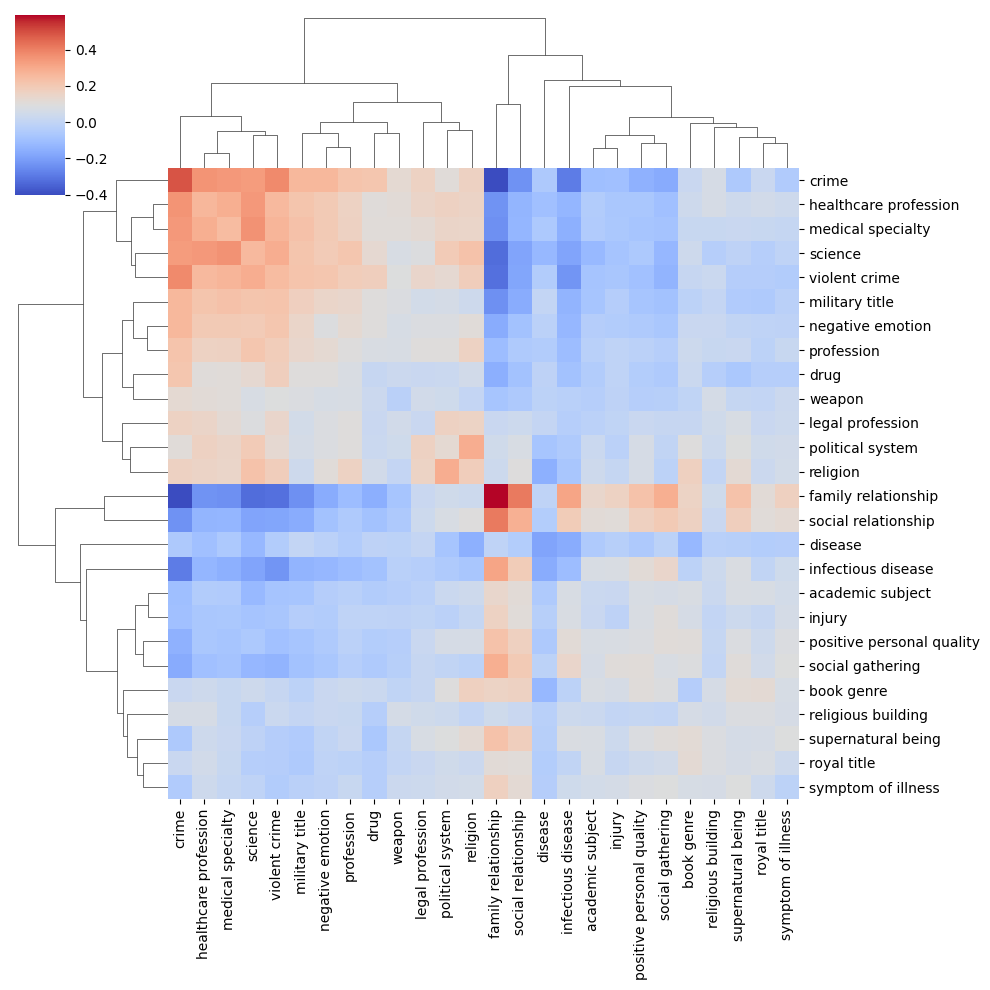

In [28]:
sns.clustermap(category_pairwise_cor_pivot.rename_axis(index=None, columns=None), cmap='coolwarm')

# Permutation test analysis



In [29]:
B = 1000

In [49]:
category_words = {c: list(set(c_words)) for c, c_words in category_words.items()}

In [50]:
def get_average_catgory(c_words):
    
    matrix = cor_matrix.loc[c_words][c_words] 
    null_values = sum(pd.isnull(matrix.values).flatten())
    total = len(matrix.values) ** 2
    value_sum = np.nansum(matrix.values) - len(matrix.values)
    average_cor = (value_sum) / (total - null_values - len(matrix.values))
          
    return average_cor, value_sum, (total - null_values - len(matrix.values))

In [51]:
def get_average_c(category_words):
    category_cs = {}
    for c, c_words in category_words.items():
        matrix = cor_matrix.loc[c_words][c_words] 
        null_values = sum(pd.isnull(matrix.values).flatten())
        total = len(matrix.values) ** 2
        value_sum = np.nansum(matrix.values) - len(matrix.values)
        average_cor = (value_sum) / (total - null_values - len(matrix.values))
        category_cs[c] = average_cor
    average_c = np.nanmean(list(category_cs.values())    )         
    return average_c,category_cs

In [38]:
#Starting the permutation

In [52]:
indices = list(cor_matrix.index)
sizes = {c: len(c_words) for c, c_words in category_words.items()}

In [53]:
random_average_cs = []
b_sizes = np.cumsum(list(sizes.values()))
all_cs = []
random_category_cs = {c: [] for c in category_cs}
for b in range(B):
    print(b)
    b_num_sums = 0
    b_den_sums = 0
    b_all_cs = []
    b_cs = []
    for c in categories:
        c_words = np.random.choice(indices, sizes[c])
        average_cor,value_sum, den = get_average_catgory(c_words) 
        random_category_cs[c].append(average_cor)
        b_cs.append(  random_category_cs[c][-1])
        b_num_sums +=  value_sum
        b_den_sums += den
    
    b_cs = np.nanmean(b_cs)
    random_average_cs.append(b_cs)
    all_cs.append(b_num_sums / b_den_sums)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [54]:
sum([all_cs_average <  x for x in all_cs]) / B

0.0

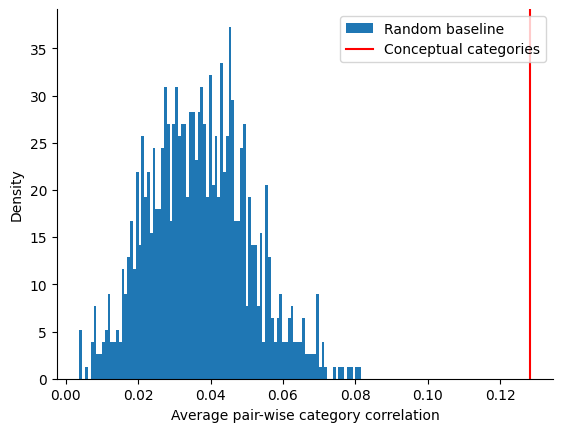

In [55]:
plt.hist(all_cs,label = 'Random baseline',density = True, bins = 100)
plt.axvline(x = all_cs_average,label = 'Conceptual categories',color = 'red')
plt.xlabel('Average pair-wise category correlation')
plt.ylabel('Density')
plt.legend()
sns.despine()